# <img src="assets/ufscar.png" alt="Logo UFScar" width="200" align="left"/><p><center>Universidade Federal de São Carlos (UFSCar)</center><br/><font size="4"><center> Departamento de Computação, campus Sorocaba </center> </font>


<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>
</p>

<br>
<font size = "4"><center><b> Grupo 5: Análise de sentimento de reviews na Amazon </b></center></font>
<br>

# Logistic Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pre_processing as pp
import analysis as anl
import pca

# Categoria da base de dados a ser lida (do disco) e processada
# [books, kitchen_&_housewares, electronics, dvd, all]
category = 'test'

# Se positivo, adiciona bigramas para reviews negativas
# ex: ('not', 'good') equivale a uma única feature
hNeg = True

# Se positivo, adiciona substantivos
noun = False

# Guarda as features ja processadas em X, a classe da amostra em Y e o vocabulario em vocabulary
# hNeg e noun sao opcionais, por padrao hNeg=True, noun=False
X, Y, vocabulary = pp.bow(category, hNeg, noun)

print("Vocabulário possui " + str(len(vocabulary)) + " palavras!")

Vocabulário possui 10768 palavras!


#### Separa os dados em treinamento e teste:

In [2]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X2, Y2 = X[idx_perm, :], Y[idx_perm]

# Porcentagem de amostras destinadas a base de treino
pTrain = 0.8

# Executa o holdout e retorna os indices de treino e teste, mantendo a proporcao original entre as classes
train_index, test_index = anl.stratified_holdOut(Y, pTrain)

# Guarda as amostras de treino e teste
Xtrain, Xval = X2[train_index, :], X2[test_index, :]
Ytrain, Yval = Y2[train_index], Y2[test_index]

#### Seleciona features com chi-quadrado (a partir dos dados de treinamento):

In [3]:
# Seta o valor de alpha para o chi-quadrado. 
# alpha e opcional, por padrão alpha = 0.05
alpha = 0.05

# Chama a funcao para executar o chi-quadrado e retorna a nova base de dados reduzida
# o novo vocabulario e os indices das features mantidas
Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary, alpha)

# Seleciona apenas as features do indice retornado pelo chi-quadrado para a base de teste
Xval = Xval[:, index]

# Converte as bases de matriz esparsa para array
Xtrain = Xtrain.toarray()
Xval = Xval.toarray()

In [4]:
print("Número de features antes do chi-quadrado: " + str(len(vocabulary)))
print("----------------------------------------")
print("Número de features após chi-quadrado: " + str(len(new_vocabulary)))
print(new_vocabulary)

Número de features antes do chi-quadrado: 10768
----------------------------------------
Número de features após chi-quadrado: 723
['corrupt', 'sean', 'anyway', 'dark', 'extremist', 'flynn', 'amazon', 'fascin', 'mysteri', 'masterpiec', 'befriend', 'victim', 'half', 'annoy', 'barzini', ('not', 'bad'), ('not', 'true'), 'drastic', 'jihad', 'unfortun', 'hatr', 'iranian', 'irresist', 'raskolnikov', 'wildlif', 'mcknight', 'equival', 'melissa', 'legendari', 'engin', 'kelsey', ('not', 'complet'), ('not', 'feel'), 'cure', 'schell', 'random', 'abl', ('not', 'bother'), 'post', 'explicit', 'negoti', ('not', 'alreadi'), 'awaken', 'went', 'fabul', 'miller', 'honestli', 'horribl', 'determin', 'europ', 'fifti', 'slant', 'beauti', ('not', 'alway'), 'shallow', ('not', 'get'), 'inaccur', ('not', 'care'), ('not', 'tri'), 'cassandra', 'finish', 'amaz', 'secondari', 'proaki', 'clark', ('not', 'thought'), 'teacher', 'bare', 'commerci', 'formula', 'ellen', 'physic', 'intens', ('not', 'cup'), 'poor', 'obviou',

#### Função auxiliar para calcular a Função Sigmóide:

In [5]:
def sigmoid(z):
    
    """
    Calcula a funcao sigmoidal  
    """
    # Verifica se z e inteiro
    if isinstance(z, int):
        g = 0
    
    # se z não é um inteiro, significa que é um array e inicia com a dimensão do array
    else:
        g = np.zeros( z.shape );

    # Calculo vetorial da funcao sigmoidal
    g = 1/(1 + np.exp(-z))
  
    return g

#### Função auxiliar para calcular a Função Custo:

Calcula a função de custo, dado um vetor de thetas (theta) e um fator de regularização (lambda_reg)

In [6]:
def funcaoCustoReg(theta, X, Y, lambda_reg):
    
    """
    Calcula o custo da regressao logística
    """
    
    # Inicializa o vetor de gradientes
    grad = np.zeros( len(theta) )
    
    # Guarda a quantidade de amostras e features
    m, n = X.shape
    
    hipotese = 0
    reg = 0
    
    # Constante para evitar erro de precisao numerica
    eps = 1e-15
    
    # Calcula a hipotese para cada amostra
    hipotese = sigmoid(np.dot(X, theta))
    
    # Calcula o custo para cada amostra
    cost = (-Y * np.log(hipotese + eps)) - ((1 - Y) * np.log(1 - hipotese + eps))
    
    # Calcula a regularizacao
    reg = (lambda_reg/(2*m) * np.sum(theta[1:] ** 2))
    
    # Calcula o custo total
    J = (1/m * np.sum(cost)) + reg
    
    # Não aplica a regularização para theta[0]
    grad[0] = (np.dot(X.T, hipotese - Y)[0])/m
    
    # Guarda os thetas da regressao
    grad[1:] = (np.dot(X.T, hipotese - Y)[1:])/m + (lambda_reg/m)*theta[1:]
                      
    return J, grad


### Gridsearch: 
Itera sobre uma lista de possíveis valores para lambda_reg e retorna o melhor

In [7]:
def gridSearch(X, Y ,Xval, Yval, iteracoes):
    
    # Possiveis valores para lambda_reg
    lambda_reg = [0.01, 0.05, 0.1, 0.5, 10, 50, 100, 500]

    # Inicializa a variavel de retorno
    bestLambda = lambda_reg[0]
    
    # Inicializa a varivel que guardara a melhor acuracia
    bestAcc = 0

    # Itera sobre os valores de lambda_reg
    for l in lambda_reg :
        # Executa a regressao linear e guarda os thetas
        theta = treinamento(X,Y, l, iteracoes)
        
        # Faz a predicao e guarda as classes preditas e a acuracia
        Ypred, acuracia = predicao(Xval, theta, Yval)
        
        # Guarda o melhor lambda de acordo com a acuracia
        if bestAcc < acuracia :
            bestLambda = l
            bestAcc = acuracia


    return bestLambda


### Treinamento:
Minimiza o custo da regressão logística, retornando um vetor de thetas ótimos.

In [8]:
import scipy
import scipy.optimize 

def treinamento(X, Y, lambda_reg, iteracoes):
        
    # Se for vazio, retorna None 
    if len(Y)==0:
        return None
    
    # m = qtde de objetos e n = qtde de atributos por objeto    
    m, n = X.shape
    
    # Inicializa parâmetros que serao ajustados
    theta = np.zeros(n) 
    
    # Minimiza a funcao de custo
    result = scipy.optimize.minimize(fun=funcaoCustoReg, x0=theta, args=(X, Y, lambda_reg),  
                method='BFGS', jac=True, options={'maxiter': iteracoes, 'disp':False})

    # Coleta os thetas retornados pela função de minimização
    theta = result.x
    
    return theta

#### Função auxiliar para predizer um conjunto de amostras:

In [9]:
def predicao(X, theta, Yval):
    
    """
    Prediz se a entrada pertence a classe 0 ou 1 usando o parametro
    theta obtido pela regressao logistica
   
    """
    
    # Quantidade de amostras na base de teste
    m = X.shape[0]   
    
    # Inicializa o vetor com as classes preditas
    p = np.zeros(m, dtype=int) 
    
    # Calcula a hipótese
    z = np.dot(X, theta)
    
    # Calcula a função sigmóide
    h_theta = sigmoid(z) 
    
    # Para cada amostra, guarda a classe com maior probabilidade
    for i in range(m):
        if h_theta[i] >= 0.5:
            p[i] = 1 
            
    acuracia = np.sum(p==Yval)/len(Yval)
    
    return p, acuracia

#### Predição da base de teste do Holdout:

In [10]:
numIter = 50
lambdaReg = gridSearch(Xtrain, Ytrain, Xval, Yval, numIter)
theta = treinamento(Xtrain, Ytrain, lambdaReg, numIter)

Ypred, acuracia = predicao(Xval, theta, Yval)
print("Acurácia é "+ str(acuracia))

classes = np.unique(Y)
auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

Acurácia é 0.915

	Revocacao   Precisao   F-medida   Classe
	0.912       0.921      0.917      0
	0.918       0.909      0.913      1
	------------------------------------------------
	0.915       0.915      0.915      Média macro
	0.915       0.915      0.915      Média micro

	Acuracia: 0.915


## Curva de Aprendizado:

In [11]:
def curva_aprendizado(Xtrain, Ytrain, Xval, Yval, lambdaReg, numIter, num_iteracoes_curva = 0):
   
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
    
    lambdaReg : fator de regularização da função de custo
    
    numIter : número de iterações da função de otimização
    
    num_iteracoes_curva : escalar indicando a quantidade de iterações da curva de aprendizado
  
    """

    # Define a quantidade de iteracoes, por padrao, itera por cada amostra da base de treino
    if (num_iteracoes_curva <= 0 or num_iteracoes_curva > len (Y)):
        num_iteracoes_curva = len (Y)
    
    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # Guarda a quantidade de classes da base
    classes = np.unique(Y)
    
    # Itera e executa a Regressão Logística com i amostras da base de treino para cada iteracao
    for i in range(10, len(Y), int (len(Y)/num_iteracoes_curva)):
        # Executa o treinamento e retorna os thetas
        theta = treinamento(Xtrain[:i], Ytrain[:i], numIter, lambdaReg)
        
        # Realiza a predição usando a base de treino e retorna a acuracia e as classes preditas
        Ypred, acuracia = predicao(Xtrain[:i], theta, Ytrain[:i])
        
        # Guarda a acuracia da iteracao usando a base de treino como teste
        perf_train.append(acuracia)

        # Realiza a predição usando a base de teste e retorna a acuracia e as classes preditas
        Ypred, acuracia = predicao(Xval, theta, Yval)
        
        # Guarda a acuracia da iteracao usando a base de validacao como teste
        perf_val.append(acuracia)

    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()



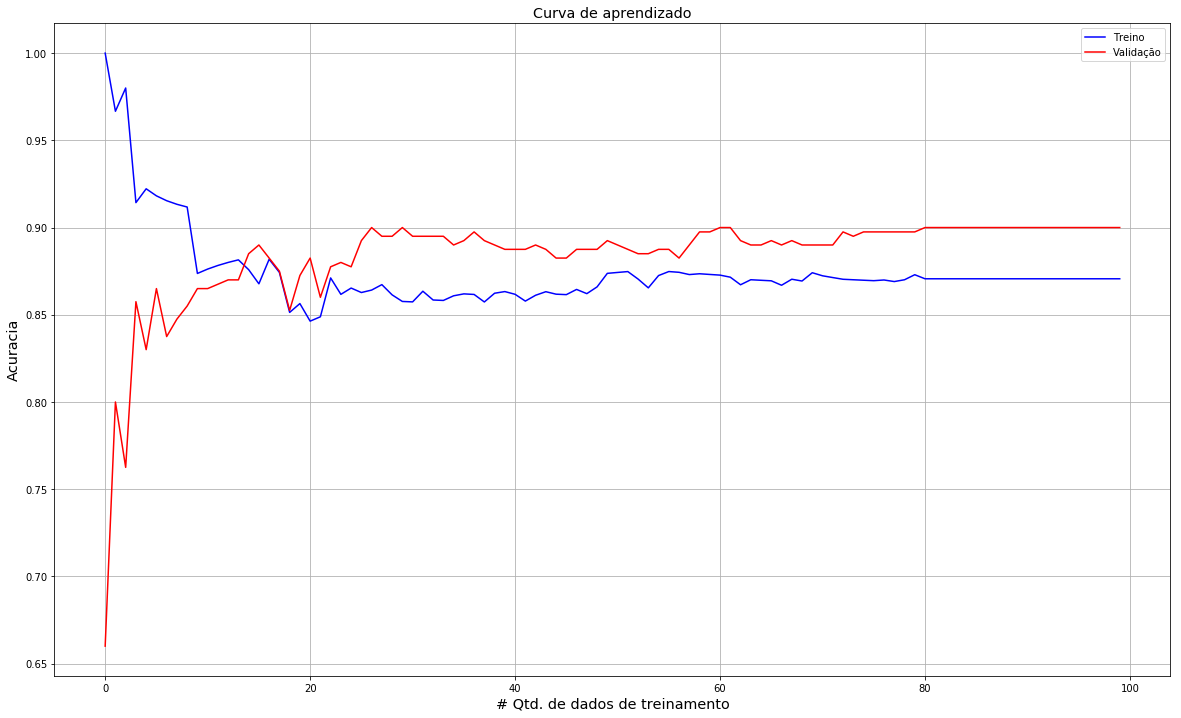

In [12]:
# lambdaReg = fator de regularizacao da regressao logistica
# numIter = numero máximo de iterações da funcao de otimizacao
# num_iteracoes_curva = numero de iteracoes da curva de aprendizado, 
# por padrao e igual ao numero de amostras da base
curva_aprendizado(Xtrain, Ytrain, Xval, Yval, lambdaReg, numIter, num_iteracoes_curva = 100)

## K-Folds

In [13]:
import k_folds as kf

#Pega todos os tipos de classes 
classes = classes = np.unique(Y)

# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X3, Y3 = X[idx_perm, :], Y[idx_perm]

# separa os dados em k folds
nFolds = 5
folds = kf.stratified_kfolds(Y3, nFolds, classes)

# Apenas para controle das iteracoes
k = 1

# cria uma lista vazia para guardar os resultados obtidos em cada fold
resultados=[] 

for train_index, test_index in folds:

    print('\n-----------\n%d-fold: \n-----------\n' % (k) )

    # se train_index ou test_index forem vazios, interrompe o laco de repeticao
    if len(train_index)==0 or len(test_index)==0: 
        print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
        break
       
    # Guarda as bases de treino e teste baseado nos índices de cada fold
    Xtrain, Xval = X3[train_index, :], X3[test_index, :];
    Ytrain, Yval= Y3[train_index], Y3[test_index];

    # Executa o chi-quadrado na base do fold atual
    Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary)
    Xval = Xval[:, index]
    
    #Converte matrizes esparsas para np arrays, para os cálculos da regressão logística
    Xtrain = Xtrain.toarray()
    Xval = Xval.toarray()

    # Numero de iteracoes da funcao de otimizacao
    numIter = 50
    
    # Executa o gridSearch e retorna o melhor fator de regularizacao 
    lambdaReg = gridSearch(Xtrain, Ytrain, Xval, Yval, numIter)
    
    print("Melhor lambda")
    print(lambdaReg)
    
    # Executa o treinamento e guarda os thetas
    theta = treinamento(Xtrain, Ytrain, lambdaReg, numIter)
    
    # Faz a predicao
    Ypred, acuracia = predicao(Xval, theta, Yval)

    # Relatorio do fold
    auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

    # adiciona os resultados do fold atual na lista de resultados
    resultados.append( auxResults )
    
    # Incremento da variavel de controle
    k = k + 1
    
kf.mediaFolds( resultados, classes )


-----------
1-fold: 
-----------

Melhor lambda
0.1

	Revocacao   Precisao   F-medida   Classe
	0.875       0.875      0.875      0
	0.875       0.875      0.875      1
	------------------------------------------------
	0.875       0.875      0.875      Média macro
	0.875       0.875      0.875      Média micro

	Acuracia: 0.875

-----------
2-fold: 
-----------

Melhor lambda
0.5

	Revocacao   Precisao   F-medida   Classe
	0.880       0.867      0.873      0
	0.865       0.878      0.872      1
	------------------------------------------------
	0.873       0.873      0.873      Média macro
	0.873       0.873      0.873      Média micro

	Acuracia: 0.873

-----------
3-fold: 
-----------

Melhor lambda
10

	Revocacao   Precisao   F-medida   Classe
	0.950       0.918      0.934      0
	0.915       0.948      0.931      1
	------------------------------------------------
	0.932       0.933      0.933      Média macro
	0.932       0.932      0.932      Média micro

	Acuracia: 0.932

----